Problem 1: Implement models in Stan

● LOs: #PythonImplementation

● Words: no specific word count; mostly code

Implement each of the models below using Stan and produce the results or plots requested for
each model. You have seen each of these models before in class.
The goal of this exercise is to learn how to implement different types of parameters, likelihood
functions, and prior distributions using Stan. Stan always generates samples for estimating
posterior distributions, while we used conjugate distributions in class. Check that your results from
Stan’s samples match the results we computed in class.

1. Call center data set – exponential likelihood with a gamma prior. Estimate the number
of calls per minute for the 13th hour of the call center data set.
Results to compute:

  ○ Posterior 98% confidence interval over λ (check that it matches results in the solution notebook below)

  ○ Histogram of posterior λ samples

In [122]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan
%matplotlib inline
waiting_times_day = np.loadtxt(
    'https://course-resources.minerva.kgi.edu/uploaded_files/mke/'
    '00124343-8397/call-center.csv')

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


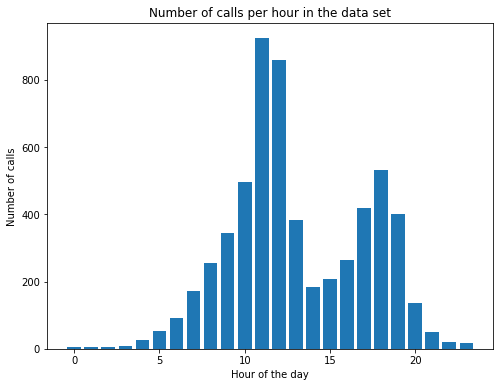

In [123]:
# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls')
plt.title('Number of calls per hour in the data set')
plt.show()

##Plot a histogram of the call wait times for hour 13


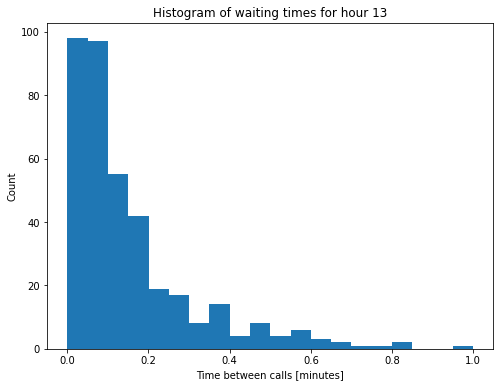

In [124]:
# Plot histogram of waiting times for one hour
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

In [125]:
call_data = {
    'alpha': 1, 
    'beta': 0.25,
    'intervals_len': len(waiting_times_hour), 
    'call_intervals': waiting_times_hour
}

In [126]:


stan_code = """

data {  
    int<lower=0> intervals_len; // number of call intervals
    real<lower=0> alpha;  // fixed prior parameter
    real<lower=0> beta;   // fixed prior parameter
    vector<lower=0>[intervals_len] call_intervals; // call intervals
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> lambda;  // we want to estimate average waiting time 
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    lambda ~ gamma(alpha, beta);  // prior 
    call_intervals ~ exponential(lambda); // likelihood function
}

"""

In [127]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4fe1966146ecda9e4dbb135f7593203f NOW.


In [128]:
stan_results = stan_model.sampling(data=call_data)
print(stan_results)

Inference for Stan model: anon_model_4fe1966146ecda9e4dbb135f7593203f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.35  8.2e-3   0.32   5.73   6.13   6.35   6.57    7.0   1518    1.0
lp__   324.43    0.02   0.69 322.33  324.3  324.7 324.87 324.92   1978    1.0

Samples were drawn using NUTS at Fri Oct 15 15:04:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 98% confidence interval for lambda: [5.60431565 7.12090549]


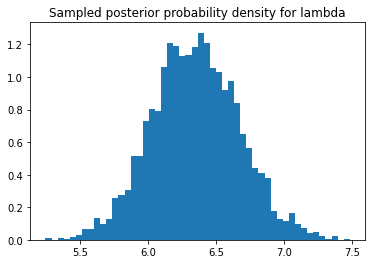

In [129]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

posterior_samples = stan_results.extract()
plt.hist(posterior_samples['lambda'], bins=50, density=True)
plt.title('Sampled posterior probability density for lambda')
print(
    "Posterior 98% confidence interval for lambda:",
    np.percentile(posterior_samples['lambda'], [1, 99]))
plt.show()

In [130]:
# Specify which parameters you want to see in the summary table using
# the "pars" keyword argument. Specify which percentiles you want to
# see using the "probs" keyword argument.
#
# The statement below shows only the 2.5, 50, 97.5 percentiles for the
# parameter p.

print(stan_results.stansummary(pars=['lambda'], probs=[0.1, 0.99]))

Inference for Stan model: anon_model_4fe1966146ecda9e4dbb135f7593203f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd    10%    99%  n_eff   Rhat
lambda   6.35  8.2e-3   0.32   5.94   7.12   1518    1.0

Samples were drawn using NUTS at Fri Oct 15 15:04:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


2. Normal likelihood with normal-inverse-gamma prior.
Results to compute:

  ○ 95% posterior confidence intervals for the mean μ and variance σ of the data.

  ○ Take 10 samples from your posterior over μ and σ and plot the normal distributions corresponding to them. See Task 3 in the solutions below – you should
produce a plot similar to the one you find there.

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(data), "data")

200 data


In [132]:
stan_data = {
    'mu_0': 0,      # The prior mean is centered around 0.
    'nu_0': 0.054,    # The smaller nu_0 is, the more uncertain we are about the prior mean.
    'alpha': 1.12,  # alpha and beta govern the marginal prior over the variance.
    'beta': 0.4,
    'input': data,
}

In [133]:
stan_code = """

data {  
    real mu_0; // mean 
    real nu_0; 
    real<lower=0> alpha;  // fixed prior parameter
    real<lower=0> beta;   // fixed prior parameter
    vector[200] input; // input data
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real mu;  //find out the mean 
    real sigma2; //find out var 

}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {

    sigma2 ~ inv_gamma(alpha, beta); //prior
    mu ~ normal(mu_0, sqrt(sigma2/nu_0));
    input ~ normal(mu, sqrt(sigma2)); // likelihood function
}
"""

In [134]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e22ac039b9a0ac51c399aaa698d64fd9 NOW.


In [135]:
stan_results = stan_model.sampling(data=stan_data)
print(stan_results)

Inference for Stan model: anon_model_e22ac039b9a0ac51c399aaa698d64fd9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       3.06  2.5e-3   0.14    2.8   2.97   3.06   3.16   3.33   2848    1.0
sigma2   3.63  6.9e-3   0.37   2.97   3.38    3.6   3.85   4.42   2788    1.0
lp__   -234.5    0.03   1.03 -237.1 -234.9 -234.2 -233.7 -233.5   1491    1.0

Samples were drawn using NUTS at Fri Oct 15 15:05:02 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval for mu: [2.80326024 3.32622025]


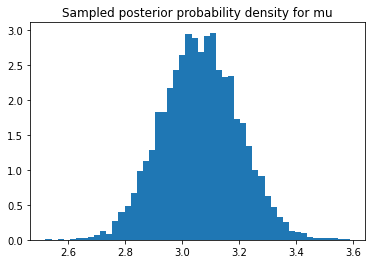

In [136]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

posterior_samples = stan_results.extract()
plt.hist(posterior_samples['mu'], bins=50, density=True)
plt.title('Sampled posterior probability density for mu')
print(
    "Posterior 95% confidence interval for mu:",
    np.percentile(posterior_samples['mu'], [2.5, 97.5]))
plt.show()

Posterior 95% confidence interval for sigma2: [2.97197275 4.41483868]


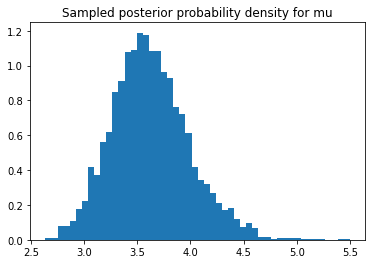

In [137]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

plt.hist(posterior_samples['sigma2'], bins=50, density=True)
plt.title('Sampled posterior probability density for sigma2')
print(
    "Posterior 95% confidence interval for sigma2:",
    np.percentile(posterior_samples['sigma2'], [2.5, 97.5]))
plt.show()

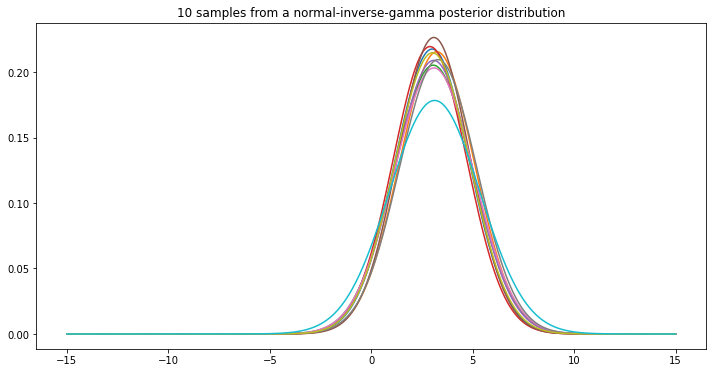

In [138]:
num_samples = 10

plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(num_samples):
    plot_y = stats.norm.pdf(plot_x, loc=posterior_samples['mu'][i], scale=np.sqrt(posterior_samples['sigma2'][i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.show()

3. Log-normal HRTEM data. Normal likelihood log-transformed data and using a
normal-inverse-gamma prior.
Results to compute:

  ● 95% posterior confidence intervals for the μ and variance σ of the log-transformed
data. (Should match results under Task 3 of the solutions.)

  ● Take 10 samples from your posterior over μ and σ and plot the log-normal
distributions corresponding to them. See Task 5 in the solutions below – you should
produce a plot similar to the one you find there, but with 10 pdfs rather than one.

In [140]:
hrtem = np.loadtxt(
    'https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv')

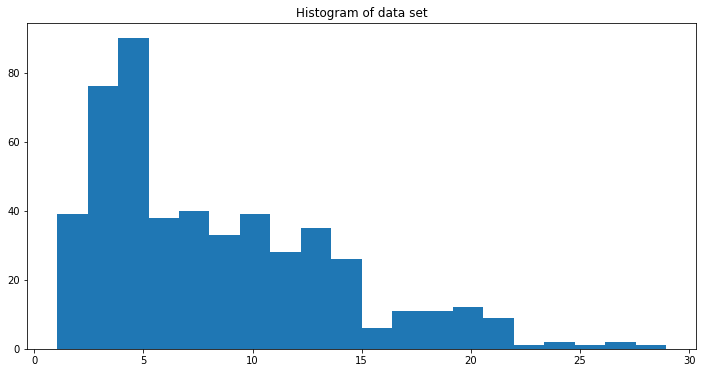

In [157]:
# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(hrtem, bins=20)
plt.title('Histogram of data set')
plt.show()

length of the data 500


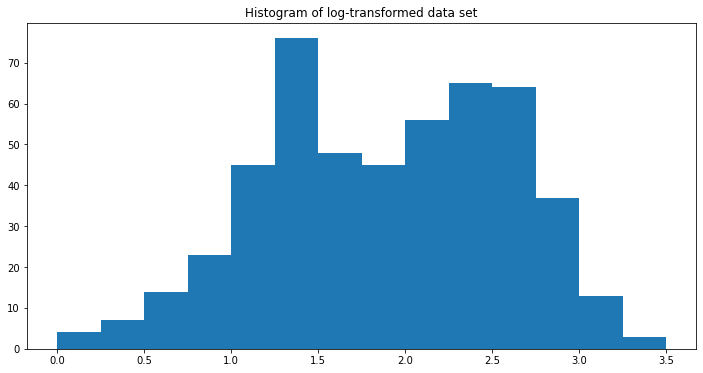

In [159]:
log_data = np.log(hrtem)
print('length of the data', len(log_data))
plt.figure(figsize=(12,6))
plt.hist(log_data, bins=np.linspace(0, 3.5, 15))
plt.title('Histogram of log-transformed data set')
plt.show()

In [146]:
stan_data = {
    'mu_0': 2.3,      # The prior mean is centered around 0.
    'nu_0': 11,    # The smaller nu_0 is, the more uncertain we are about the prior mean.
    'alpha': 9.56,  # alpha and beta govern the marginal prior over the variance.
    'beta': 23.55,
    'input': log_data,
}

In [155]:
stan_code = """

data {  
    real mu_0; // mean 
    real nu_0; 
    real<lower=0> alpha;  // fixed prior parameter
    real<lower=0> beta;   // fixed prior parameter
    vector[500] input; // input log data
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real mu;  //find out the mean 
    real sigma2; //find out var 

}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {

    sigma2 ~ inv_gamma(alpha, beta); //prior
    mu ~ normal(mu_0, sqrt(sigma2/nu_0));
    input ~ normal(mu, sqrt(sigma2)); // likelihood function
}
"""

In [156]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd82c5f558fcbff668843fd04a3c4647 NOW.


In [160]:
stan_results = stan_model.sampling(data=stan_data)
print(stan_results)

Inference for Stan model: anon_model_dd82c5f558fcbff668843fd04a3c4647.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu        1.9  5.7e-4   0.03   1.84   1.88    1.9   1.92   1.97   3366    1.0
sigma2   0.56  6.0e-4   0.03   0.49   0.53   0.56   0.58   0.63   3262    1.0
lp__   -105.3    0.02   1.02 -108.1 -105.7 -105.0 -104.6 -104.3   1751    1.0

Samples were drawn using NUTS at Fri Oct 15 15:14:41 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval for mu: [1.8384223  1.96805775]


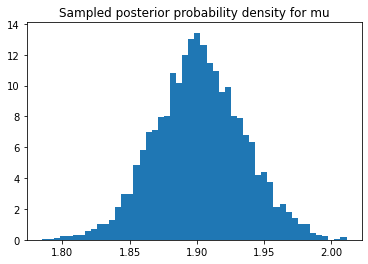

Posterior 95% confidence interval for sigma2: [0.49296937 0.6276835 ]


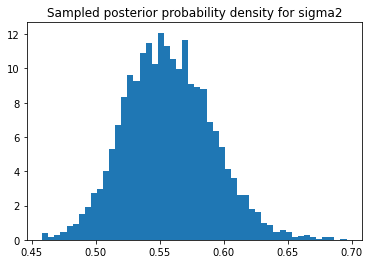

In [164]:
posterior_log_samples = stan_results.extract()

plt.hist(posterior_log_samples['mu'], bins=50, density=True)
plt.title('Sampled posterior probability density for mu')
print(
    "Posterior 95% confidence interval for mu:",
    np.percentile(posterior_log_samples['mu'], [2.5, 97.5]))
plt.show()

plt.hist(posterior_log_samples['sigma2'], bins=50, density=True)
plt.title('Sampled posterior probability density for sigma2')
print(
    "Posterior 95% confidence interval for sigma2:",
    np.percentile(posterior_log_samples['sigma2'], [2.5, 97.5]))
plt.show()

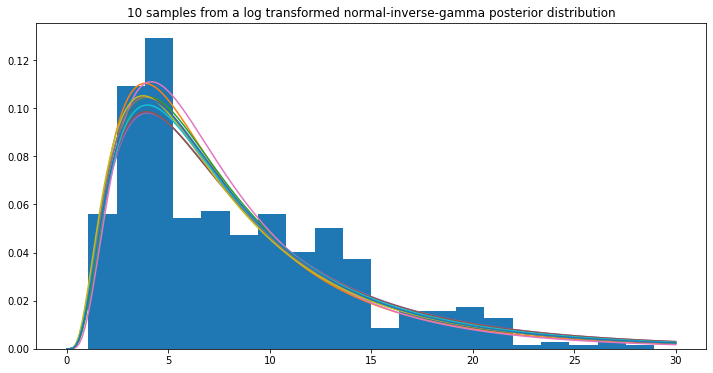

In [168]:
num_samples = 10

plt.figure(figsize=(12, 6))
plt.hist(hrtem, bins=20, density=True)
plot_x = np.linspace(0, 30, 200)
for i in range(num_samples):
    plot_y = stats.lognorm.pdf(plot_x, np.sqrt(posterior_log_samples['sigma2'][i]), scale=np.exp(posterior_log_samples['mu'][i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a log transformed normal-inverse-gamma posterior distribution' % num_samples)
plt.show()